In [1]:
#importing library

In [2]:
import numpy as np 
import pandas as pd 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [7]:
FINE_TUNING_EPOCHS = 3
TRAINING_EPOCHS = 3
BATCH_SIZE = 32
image_height = 224 
image_width = 224

https://data.mendeley.com/datasets/5y9wdsg2zt/2 data source

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
base_dir = "C:/Users/HP/Downloads/archive (4)/"
base_dataset = image_dataset_from_directory(
    base_dir,
    image_size = (image_height, image_width),
    crop_to_aspect_ratio = True,
    shuffle = False,
    batch_size = 32)

Found 40000 files belonging to 2 classes.


In [9]:
base_df = pd.DataFrame(base_dataset.file_paths.copy())
base_df.columns = ['fullpaths']
base_df['labels'] = base_df.apply(lambda x: base_dataset.class_names[1] if (base_dataset.class_names[1] in x.fullpaths) 
                                  else base_dataset.class_names[0], axis=1)
base_df['filepaths'] = base_df.apply(lambda x: str(x.fullpaths).replace(base_dir, ''), axis=1)

In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
base_df.head(10)

,fullpaths,labels,filepaths
0,C:/Users/HP/Downloads/archive (4)/Negative\00001.jpg,Negative,Negative\00001.jpg
1,C:/Users/HP/Downloads/archive (4)/Negative\00002.jpg,Negative,Negative\00002.jpg
2,C:/Users/HP/Downloads/archive (4)/Negative\00003.jpg,Negative,Negative\00003.jpg
3,C:/Users/HP/Downloads/archive (4)/Negative\00004.jpg,Negative,Negative\00004.jpg
4,C:/Users/HP/Downloads/archive (4)/Negative\00005.jpg,Negative,Negative\00005.jpg
5,C:/Users/HP/Downloads/archive (4)/Negative\00006.jpg,Negative,Negative\00006.jpg
6,C:/Users/HP/Downloads/archive (4)/Negative\00007.jpg,Negative,Negative\00007.jpg
7,C:/Users/HP/Downloads/archive (4)/Negative\00008.jpg,Negative,Negative\00008.jpg
8,C:/Users/HP/Downloads/archive (4)/Negative\00009.jpg,Negative,Negative\00009.jpg
9,C:/Users/HP/Downloads/archive (4)/Negative\00010.jpg,Negative,Negative\00010.jpg


In [12]:
freq = base_df['labels'].value_counts()
print(freq)

Negative    20000
Positive    20000
Name: labels, dtype: int64


<AxesSubplot:title={'center':'given_data_set'}, ylabel='labels'>

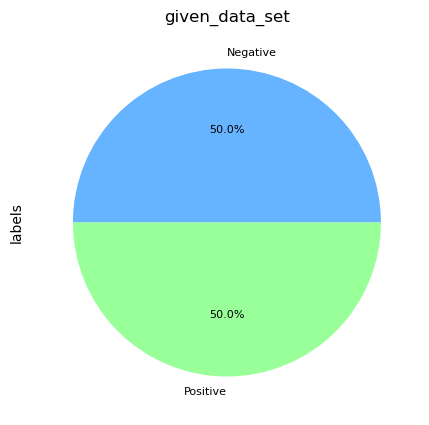

In [72]:
freq.plot(kind='pie', figsize=(5, 5), title='given_data_set', 
          autopct='%1.1f%%', shadow=False, fontsize=8, colors=['#66b3ff','#99ff99'])

In [15]:
# 60% - train set,
# 20% - validation set,
# 20% - test set
train_df, valid_df, test_df = np.split(base_df.sample(frac=1, random_state=42),
                                       [int(.6*len(base_df)), int(.8*len(base_df))])

In [16]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [17]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = True,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

In [18]:
train_generator = gen.flow_from_dataframe(
    train_df, 
    directory = base_dir, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = "rgb",
    target_size = (image_height, image_width), 
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 24000 validated image filenames belonging to 2 classes.


In [19]:
# Data agumentation and pre-processing 
test_gen = ImageDataGenerator(rescale = 1./255.)
validation_generator = test_gen.flow_from_dataframe(
    valid_df, 
    directory   = base_dir, 
    x_col       = 'filepaths',
    y_col       = 'labels',
    color_mode  ="rgb",
    target_size = (image_height, image_width), 
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    directory   = base_dir,
    x_col       = 'filepaths',
    y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False)

Found 8000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [20]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys()) 

In [21]:
import matplotlib.pyplot as plt
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])]) 

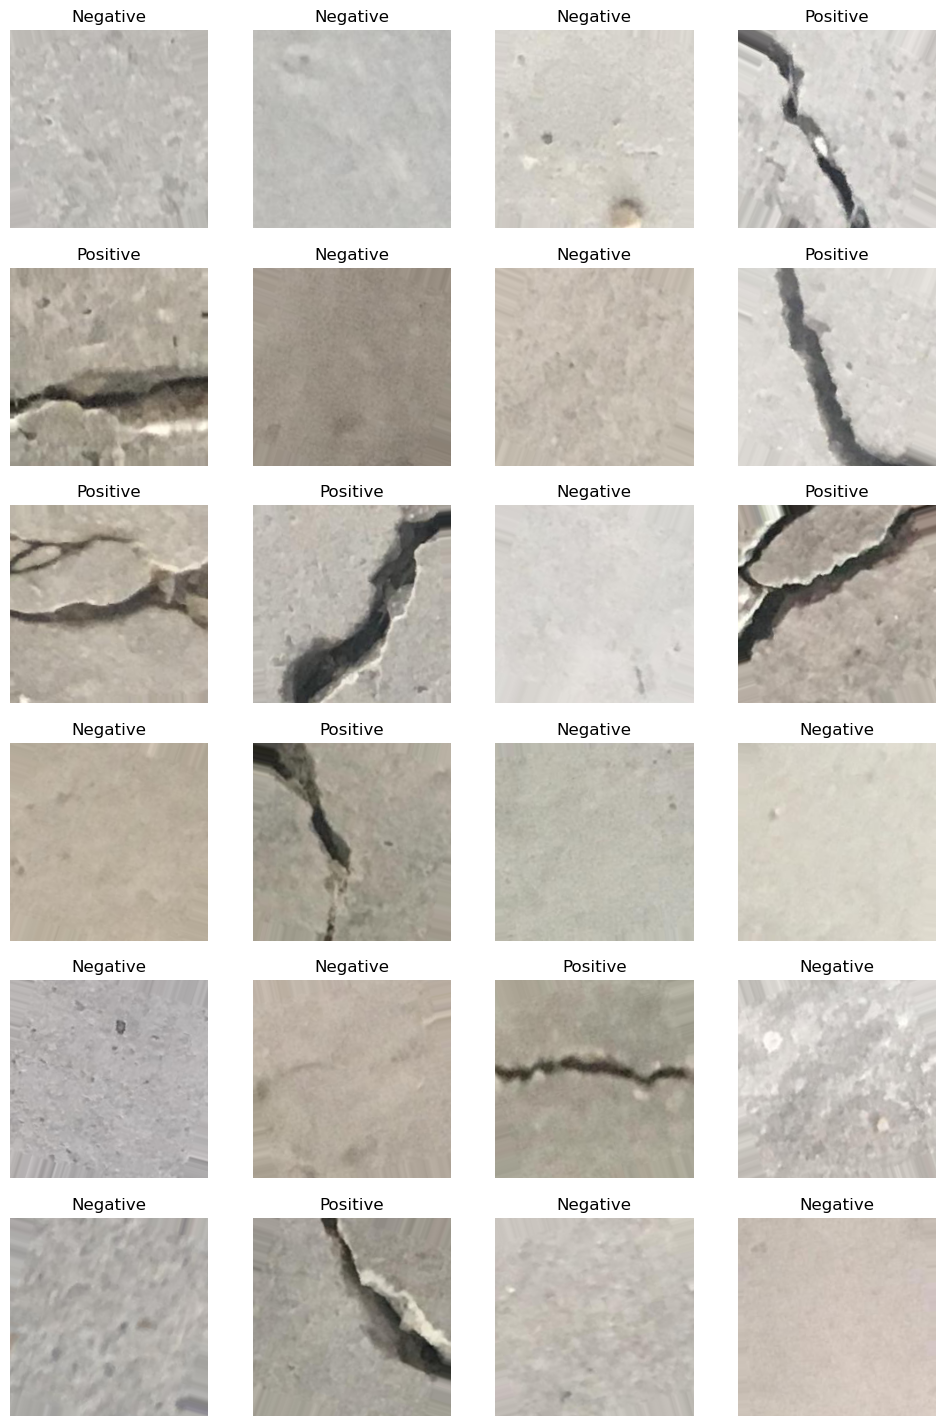

In [22]:
x,y = next(train_generator)
plot_images(x,y)

In [26]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)

In [38]:
from tensorflow.keras.models import Model
def create_model(base_model):
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(len(class_names), activation='softmax')(x)
    model = Model(base_model.inputs, outputs)
    return model 


In [37]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    print("Unfreezing number of layers in base model = ", fine_tune)
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

In [40]:
#load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )
inception_model = create_model(inception_base_model)
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)



219055592/219055592 [==============================] - 43s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/3


750/750 [==============================] - 4655s 6s/step - loss: 0.0448 - accuracy: 0.9855 - val_loss: 0.0096 - val_accuracy: 0.9965
Epoch 2/3
750/750 [==============================] - 5218s 7s/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0094 - val_accuracy: 0.9965
Epoch 3/3
750/750 [==============================] - 4653s 6s/step - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.0103 - val_accuracy: 0.9965


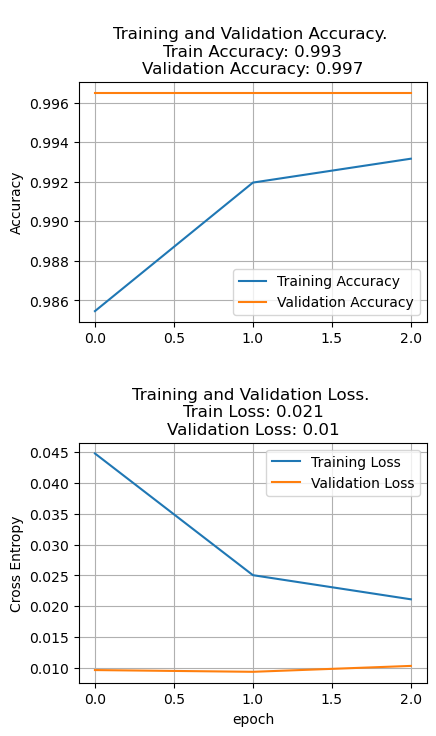

In [41]:
plot_history(history)

In [43]:
accuracy_score = inception_model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

250/250 [==============================] - 1409s 6s/step - loss: 0.0126 - accuracy: 0.9955
[0.01260473020374775, 0.9955000281333923]
Accuracy: 99.55%
Loss: 0.013


In [45]:
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

250/250 [==============================] - 1124s 4s/step


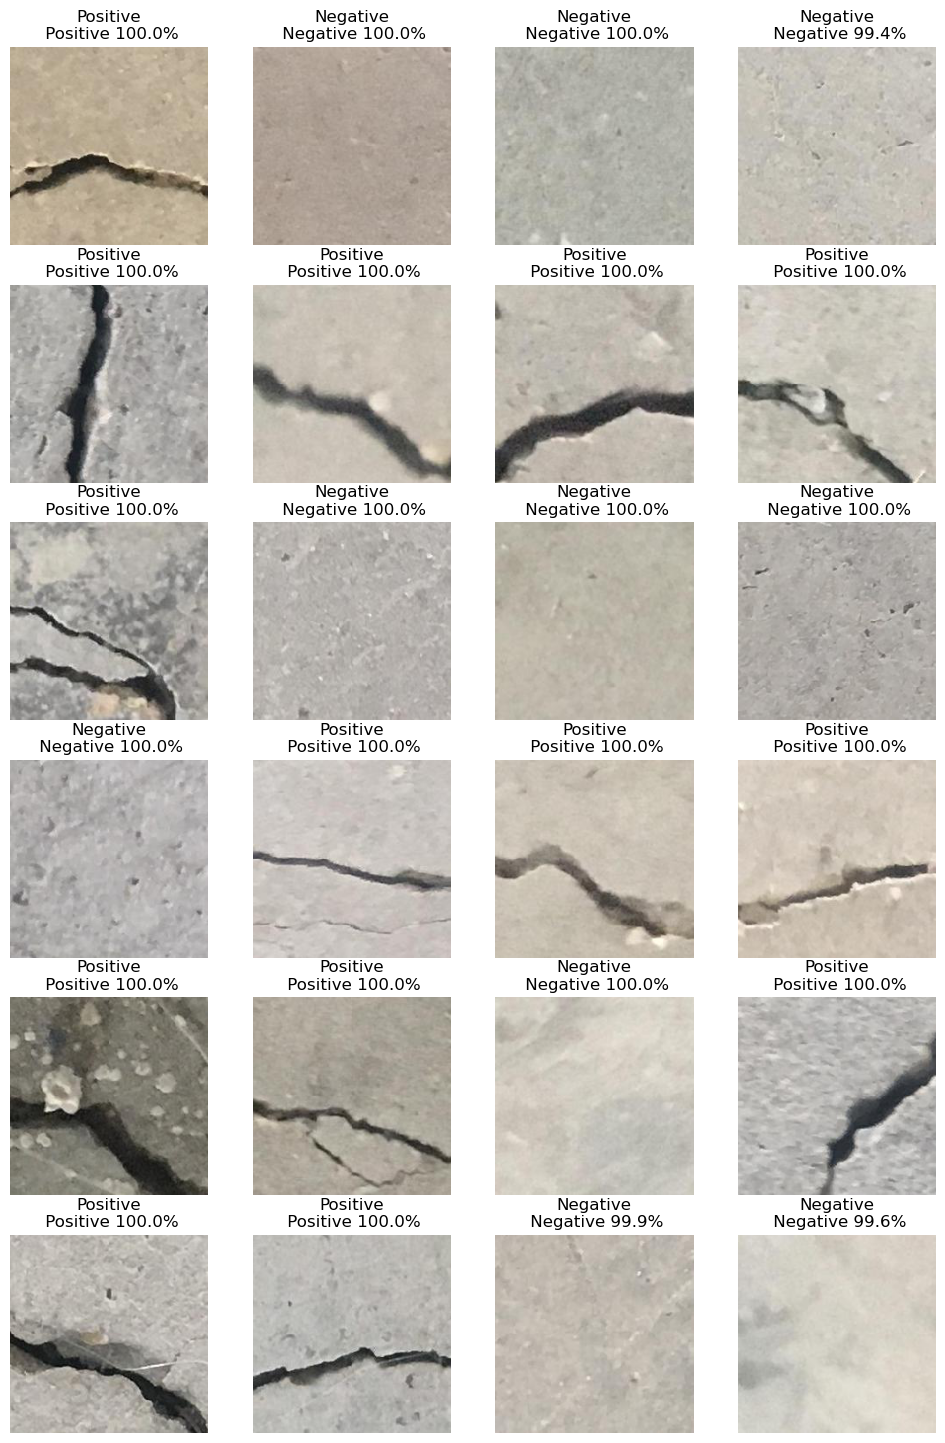

In [46]:
test_generator.reset()
x, y = next(test_generator)
plot_images(x, y, inception_test_preds)

1/1 [==============================] - 0s 280ms/step


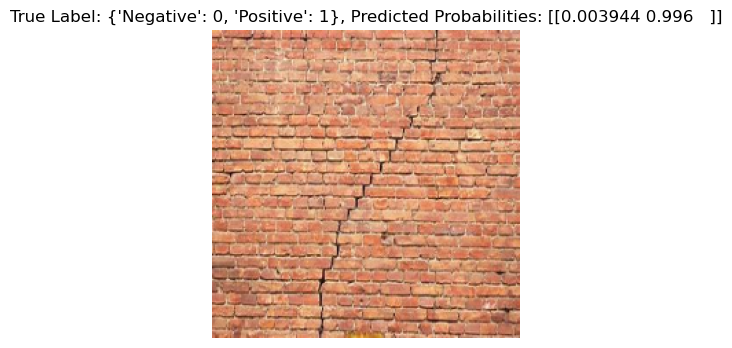

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def preprocess_image(image_path):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    img = cv2.resize(img, (224, 224))  # Resize to match model's expected sizing
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def plot_images(image, true_label, predicted_probs):
    # Plot the image with true label and predicted probabilities
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Predicted Probabilities: {predicted_probs}')
    plt.axis('off')
    plt.show()
image_path = 'E:\crack_concrete.jpg'

image_size = 224  

# Preprocess the image
image = preprocess_image(image_path)


predictions = inception_model .predict(image)


predicted_class = np.argmax(predictions[0])  
predicted_probabilities = predictions[0]


true_label = a  # Replace with the actual true label

# Plot the image and predictions
plot_images(np.squeeze(image), true_label,predictions)

In [85]:
inception_model.save("Addisu_pth",save_format='tf')

INFO:tensorflow:Assets written to: Addisu_pth\assets


INFO:tensorflow:Assets written to: Addisu_pth\assets
